# Cuda setup
Check if cuda is available.

In [11]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


# Import data from source
METHOD 1: install yfinance in the environment hosting python and jupyter. I used Anaconda, and installed through conda terminal into my environment.

*pip install yfinance*

Use the yfinance API to retrieve company data

In [12]:
# yahoo finance api to collect stock data
import yfinance as yf
import os

# datetime imports to work with dates
from datetime import date
from dateutil.relativedelta import relativedelta

# alpaca api to collect stock data
from alpaca_trade_api.rest import REST, TimeFrame, TimeFrameUnit

# Process data from csv files
Use pandas library for processing files, and use matplotlib to display graphs and visualizations.

In [13]:
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
%matplotlib inline

import torch.optim.lr_scheduler as lr_scheduler

In [14]:
#Change directory for Lorne's jupyter notebook
# I am mixing windows and wsl on windows so I need to manaually change the directory, so you won't need to when you run it
if True:
    # See files in current directory
    import os

    current_directory = os.getcwd()
    print(current_directory)

    entries = os.listdir('.')
    files = [entry for entry in entries if os.path.isfile(entry)]

    for file_name in files:
        print(file_name)

    %cd "/mnt/c/Users/LPC/Documents/GitHub/CSCI611-NNSTOCKS"

    current_directory = os.getcwd()
    print(current_directory)

    entries = os.listdir('.')
    files = [entry for entry in entries if os.path.isfile(entry)]

    # Print the names of the files
    for file_name in files:
        print(file_name)

/mnt/c/Users/LPC/Documents/GitHub/CSCI611-NNSTOCKS
AAPL_intraday.csv
AAPL_intraday1.csv
AMD_intraday.csv
AMD_intraday1.csv
first_try.ipynb
README.md
RNN.ipynb
/mnt/c/Users/LPC/Documents/GitHub/CSCI611-NNSTOCKS
/mnt/c/Users/LPC/Documents/GitHub/CSCI611-NNSTOCKS
AAPL_intraday.csv
AAPL_intraday1.csv
AMD_intraday.csv
AMD_intraday1.csv
first_try.ipynb
README.md
RNN.ipynb


In [15]:
class StockDataset(torch.utils.data.Dataset[float]):
    def __init__(self, sequences, targets):
        super(StockDataset).__init__()
        self.sequences = sequences
        self.targets = targets
    def __len__(self):
        return len(self.sequences)    
    def __getitem__(self, index):
        sequence = torch.tensor(self.sequences[index], dtype=torch.float32).unsqueeze(-1)#sequence at index 
        target = torch.tensor(self.targets[index], dtype=torch.float32)#test_value at index
        return sequence, target


In [16]:
# Generate stock price data from yahoo finance 
def get_yahoo_stock_data(name, interval="5m", period="7d"):
    data = yf.download(name, interval=interval, period=period)
    return data

def get_alpaca_stock_data(name, interval="15", months="6"):
    name_of_file = name + "_intraday1.csv"

    start_date = date(2021, 6, 1)
    end_date = start_date + relativedelta(months=int(months))  # Adds months

    api = REST('PKJ41QP5QU0TYS4S1BYB', 'o5HVFGx0XWSMoMyeQdRJwG1apYXtuMNcguWpjqqe')

    data = api.get_bars(name, TimeFrame(int(interval), TimeFrameUnit.Minute), start_date, end_date, adjustment='raw').df

    data = data.rename(columns={"close": "Close", "open": "Price", "high": "High", "low": "Low", "volume": "Volume", "datetime": "Datetime", "ticker": "Ticker"})

    data.to_csv(name_of_file)

    return name_of_file

In [17]:
def plot_loss(training_loss_array, validation_loss_array, epochs):
    # Create the plot
    plt.figure(figsize=(10, 6))

    # Plot training loss
    plt.plot(range(1, int((epochs)/10) + 1), training_loss_array, marker='o', linestyle='-', color='b', label='Training Loss')

    # Plot validation loss
    plt.plot(range(1, int((epochs)/10) + 1), validation_loss_array, marker='x', linestyle='--', color='r', label='Validation Loss')

    # Add title and labels
    plt.title('Training vs Validation Loss Over Epochs')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')

    # Add grid and legend
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    # Add x-axis ticks
    plt.xticks(range(1, (int((epochs + 1)/10)+1), 1))

    # Show the plot
    plt.show()

# Display relevant information for formatting purposes

In [18]:
class RNN_initializer:
    #
    def __init__(self, retrieve, name, recomp, nval, ival, pval, batch_size, num_workers, epochs, learning_rate, lr_scheduler_rate, beta1, beta2):
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.lr_scheduler_rate = lr_scheduler_rate
        self.beta1 = beta1
        self.beta2 = beta2
        if(retrieve == True):
            if (stock_data_source == "yahoo"):
                self.csv_name = self.retrieve_csv(name, recomp, nval, str(ival[0])+ival[1], str(pval[0])+pval[1])
            else:
                self.csv_name = get_alpaca_stock_data(name, stock_interval, stock_period)
        else:
            self.csv_name = name
        self.df=pd.read_csv(name + "_intraday1.csv")
        #format data, and prepare it for RNN
        if(stock_data_source == "yahoo"):
            price = self.df['Close'].to_list()[2:]
        else:
            price = self.df['Close'].to_list()[2:]
        self.axis_labels = self.df['Price'].to_list()[2:]
        date_format_with_time = "%Y-%m-%d %H:%M:%S"
        self.price_inputs = [float(x) for x in price]
        sequence_length = 6
        #Training sets
        self.train_seq = []
        self.train_tar = []
        #Validation sets
        self.valid_seq = []
        self.valid_tar = []
        #Testing sets
        self.test_seq = []
        self.test_tar = []
        #choose a selected time range
        train_range = len(self.price_inputs)//pval[0] * (pval[0]-1)
        test_range_beg = train_range
        test_range_end = train_range + len(self.price_inputs)//pval[0]
        #generate sequences and targets list for loading data
        for i in range(train_range - sequence_length):
            seq = self.price_inputs[i:i+sequence_length]
            self.train_seq.append(seq)
            temp = self.price_inputs[i+sequence_length]
            self.train_tar.append(temp)
        for j in range(test_range_beg, test_range_end-sequence_length):
            seq = self.price_inputs[j:j+sequence_length]
            self.test_seq.append(seq)
            temp = self.price_inputs[j+sequence_length]
            self.test_tar.append(temp)
        train_data = StockDataset(self.train_seq, self.train_tar)
        test_data = StockDataset(self.test_seq, self.test_tar)
        
        self.train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
        #valid_loader = torch.utils.data.DataLoader(self.test_vals, batch_size=batch_size, 
        #sampler=valid_sampler, num_workers=num_workers)
        self.test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)
    # retreive_csv is a file that allows the user to extract stock data from yahoo finance.
    # @param: name, name of file
    # @param: recomp, indicates if file needs to be recompiled
    # @param: num, indicates which file need to be recompiled
    def retrieve_csv(self, name, recomp, nval, ival, pval):
        # Example: Get 1-minute intraday data for Apple (AAPL) for 1 day
        data = get_yahoo_stock_data(stock_name, stock_interval, stock_period)
        ext = ".csv"
        pt2 = "_intraday"
        num = 1;
        file_name = name + pt2 + str(num) + ext
        found = False
        if(recomp!=True):
            while(found!=True):
                if os.path.isfile(file_name):
                    num+=1
                    file_name = name + pt2 + str(num) + ext
                else:
                    found = True
        else:
            if(nval >= 1):
                file_name = name + pt2 + str(nval) + ext
            else:
                file_name = name + pt2 + ext
        data.to_csv(file_name)
        return file_name

    def display_fig(self):
        plt.figure(figsize=(20, 20))
        plt.title(name + " Intraday Stock Price")
        plt.plot(self.axis_labels, self.price_inputs)
        plt.xlabel("time")
        plt.ylabel("price")
        plt.xticks(self.axis_labels[::26])
        plt.yticks(self.price_inputs[::30])
        plt.show()

    def show_df_info(self):
        self.df.head(15)
        self.df.tail(10)
        print("Row count: " + len(self.price_inputs))
        print("Selected range: " + selected_range)
        
    def trainAndTest(self):
        #RNN model
        self.rnn1 = RNN()
        # move tensors to GPU if CUDA is available
        min_loss = np.inf

        if train_on_gpu:
            self.rnn1.cuda()
        #use MSELoss instead of MSEAbsoluteLoss (predicting next price compared to next change)
        error = nn.MSELoss()
        # specify optimizer
        optimizer = torch.optim.Adam(self.rnn1.parameters(), lr=self.learning_rate, betas=(beta1, beta2))
        #optimizer = optim.SGD(model.parameters(), lr=0.01)
        #self.price_tensor = torch.tensor(self.sequences, dtype=torch.float32).unsqueeze(-1)#input 
        #self.y_tensor = torch.tensor(self.test_vals, dtype=torch.float32)#test_values
        # Learning rate scheduler
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=self.lr_scheduler_rate, patience=10)
        valid_loss_min = np.inf
        for epoch in range(epochs):
            train_loss = 0.0
            valid_loss = 0.0
            #TRAINING
            self.rnn1.train()
            for batch_idx, (data, target) in enumerate(self.train_loader):
                # move tensors to GPU if CUDA is available
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()
                # clear the gradients of all optimized variables
                optimizer.zero_grad()
                # forward pass: compute predicted outputs by passing inputs to the model
                output = self.rnn1(data)
                # calculate the batch loss
                loss_train = error(output, target)
                # backward pass: compute gradient of the loss with respect to model parameters
                loss_train.backward()
                # perform a single optimization step (parameter update)
                optimizer.step()
                train_loss += loss_train.item()*data.size(0)
                if (loss_train < min_loss):
                    min_loss = loss_train
                    #torch.save(self.rnn1.state_dict(), "rnn1.pth")

            scheduler.step(train_loss)  # Update learning rate

            self.rnn1.eval()
            for batch_idx, (data, target) in enumerate(self.test_loader):
                # move tensors to GPU if CUDA is available
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()
                # forward pass: compute predicted outputs by passing inputs to the model
                output = self.rnn1(data)
                # calculate the batch loss
                loss_valid = error(output, target)
                # perform a single optimization step (parameter update)
                valid_loss += loss_valid.item()*data.size(0)
                if (loss_valid < min_loss):
                    min_loss = loss_valid
                    #torch.save(self.rnn1.state_dict(), "rnn1.pth")
        
            if (epoch+1) % 10 == 0:
                lr = optimizer.param_groups[0]["lr"]
                print(f"Training: Epoch {epoch+1}/{epochs}, Loss: {loss_train.item():.6f}")
                print(f"                  Validation: Epoch {epoch+1}/{epochs}, Loss: {loss_valid.item():.6f}")
                training_loss_array.append(int(loss_train.item()))
                validation_loss_array.append(int(loss_valid.item()))

        return min_loss
        
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn1 = nn.RNN(input_size=1, hidden_size=128, num_layers=2, nonlinearity='tanh', bias=True, batch_first=True, dropout=0.0, bidirectional=False, device=None, dtype=None)
        self.fc = nn.Linear(128, 1)
        
    def forward(self, x):
        self.output, self.hidden = self.rnn1(x)
        prediction = self.fc(self.output[:, -1, :])
        return prediction
        


In [9]:
#Stock variables used when collecting stock data
#Choose which api to use to grab stock data, either "yahoo" or "alpaca"
stock_data_source = "alpaca"

#Loss array used to store loss values for each 10 epochs, reset each set of hyperparameters
training_loss_array = []
validation_loss_array = []
test_loss = np.inf

#Stock variables when using yahoo finance api
if stock_data_source == "yahoo":
    stock_name = "AMD"
    stock_interval="5m"
    stock_period="7d"
    epochs = 100
    lr_scheduler_rate = 0.8
    beta1 = 0.9
    beta2 = 0.999

#Stock variables when using alpaca api
if stock_data_source == "alpaca":
    stock_name = "AMD"
    stock_interval="15"
    stock_period="24" #months
    epochs = 200
    lr_scheduler_rate = 0.1
    beta1 = 0.95
    beta2 = 0.999

batch_size = 16
num_workers = 0

In [10]:
#test various learning rates
learning_rate_list = [0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]
best_lr = [[np.inf, np.inf] , [np.inf, np.inf]] #record two pairs of [loss, learning rate] to tune learning rate later
best_lr_in_loop = np.inf
repeated_loops_per_lr = 1

for lr in learning_rate_list:
    print("\n\n-------------------------------------------------------------------------------")
    print("Learning rate: ", lr, "   Loop: ", repeated_loops_per_lr)
    print(stock_name, "Time interval ", stock_interval, "min", "Time period: ", stock_period, 'months')
    print("Batch size: ", batch_size, "Number of workers: ", num_workers, "Epochs: ", epochs)
    print("Learning rate scheduler rate: ", lr_scheduler_rate)
    print("Beta1: ", beta1, "Beta2: ", beta2)
    print("-------------------------------------------------------------------------------")
    
    for i in range(repeated_loops_per_lr):
        training_loss_array = []
        validation_loss_array = []
        rnn1 = RNN_initializer(retrieve=True, name=stock_name, recomp=True, nval=1, ival=[5, "m"], pval=[7,"d"], batch_size=batch_size, num_workers=num_workers, epochs=epochs, learning_rate=lr, lr_scheduler_rate=lr_scheduler_rate, beta1=beta1, beta2=beta2)
        loss = rnn1.trainAndTest()
        if best_lr_in_loop > loss:
            best_lr_in_loop = loss

    if best_lr_in_loop < best_lr[0][0]:
        best_lr[1] = best_lr[0]
        best_lr[0] = [best_lr_in_loop, lr]
    elif best_lr_in_loop < best_lr[1][0]:
        best_lr[1] = [best_lr_in_loop, lr]

    best_lr_in_loop = np.inf

    #plot_loss(training_loss_array, validation_loss_array, epochs)

print("\n\nBest learning rate: ", best_lr[0][1], "   Loss: ", best_lr[0][0])
print("Second best learning rate: ", best_lr[1][1], "   Loss: ", best_lr[1][0])






-------------------------------------------------------------------------------
Learning rate:  0.005    Loop:  1
AMD Time interval  15 min Time period:  24 months
Batch size:  16 Number of workers:  0 Epochs:  200
Learning rate scheduler rate:  0.1
Beta1:  0.95 Beta2:  0.999
-------------------------------------------------------------------------------


/home/lb/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/lb/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/lb/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  retur

Training: Epoch 10/200, Loss: 29.409237
                  Validation: Epoch 10/200, Loss: 1064.005615
Training: Epoch 20/200, Loss: 29.409725
                  Validation: Epoch 20/200, Loss: 1064.003174
Training: Epoch 30/200, Loss: 20.431971
                  Validation: Epoch 30/200, Loss: 1787.949829


KeyboardInterrupt: 



-------------------------------------------------------------------------------
Learning rate:  0.0005    Loop:  1
AMD Time interval  15 min Time period:  6 months
Batch size:  16 Number of workers:  0 Epochs:  100
Learning rate scheduler rate:  0.75
Beta1:  0.95 Beta2:  0.999
-------------------------------------------------------------------------------


/home/lb/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/lb/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Training: Epoch 10/100, Loss: 1050.627930
                  Validation: Epoch 10/100, Loss: 2059.042969
Training: Epoch 20/100, Loss: 1042.747681
                  Validation: Epoch 20/100, Loss: 2048.115479
Training: Epoch 30/100, Loss: 1081.337402
                  Validation: Epoch 30/100, Loss: 2103.617432
Training: Epoch 40/100, Loss: 1154.221191
                  Validation: Epoch 40/100, Loss: 2204.680176
Training: Epoch 50/100, Loss: 1141.018066
                  Validation: Epoch 50/100, Loss: 2187.702637
Training: Epoch 60/100, Loss: 1157.518555
                  Validation: Epoch 60/100, Loss: 2206.790527
Training: Epoch 70/100, Loss: 1215.330322
                  Validation: Epoch 70/100, Loss: 2291.923340
Training: Epoch 80/100, Loss: 1068.205444
                  Validation: Epoch 80/100, Loss: 2088.036865
Training: Epoch 90/100, Loss: 576.787109
                  Validation: Epoch 90/100, Loss: 1370.775757
Training: Epoch 100/100, Loss: 296.372314
                  Valid

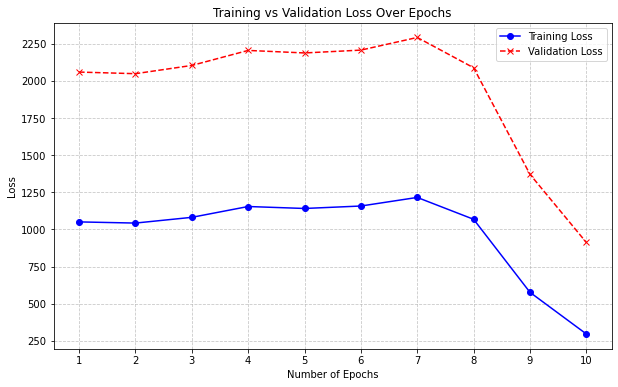



-------------------------------------------------------------------------------
Learning rate:  0.000455    Loop:  1
AMD Time interval  15 min Time period:  6 months
Batch size:  16 Number of workers:  0 Epochs:  100
Learning rate scheduler rate:  0.75
Beta1:  0.95 Beta2:  0.999
-------------------------------------------------------------------------------


/home/lb/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/lb/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Training: Epoch 10/100, Loss: 1083.437500
                  Validation: Epoch 10/100, Loss: 2105.646973
Training: Epoch 20/100, Loss: 1048.989136
                  Validation: Epoch 20/100, Loss: 2057.458740
Training: Epoch 30/100, Loss: 1067.800293
                  Validation: Epoch 30/100, Loss: 2083.640381
Training: Epoch 40/100, Loss: 1113.418213
                  Validation: Epoch 40/100, Loss: 2148.614258
Training: Epoch 50/100, Loss: 1152.867310
                  Validation: Epoch 50/100, Loss: 2204.450439
Training: Epoch 60/100, Loss: 1290.764160
                  Validation: Epoch 60/100, Loss: 2394.519287
Training: Epoch 70/100, Loss: 1224.033203
                  Validation: Epoch 70/100, Loss: 2263.520996
Training: Epoch 80/100, Loss: 725.617188
                  Validation: Epoch 80/100, Loss: 1595.949463
Training: Epoch 90/100, Loss: 342.377563
                  Validation: Epoch 90/100, Loss: 992.477356
Training: Epoch 100/100, Loss: 227.421387
                  Validat

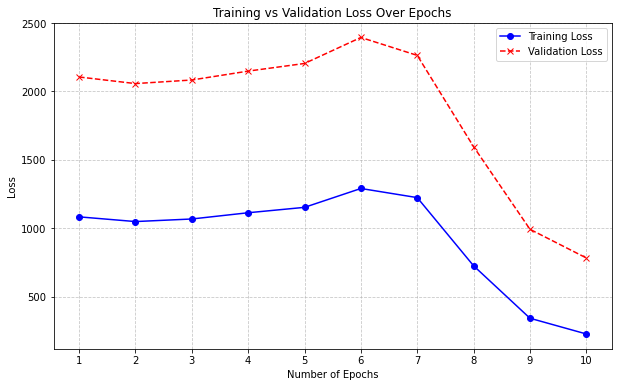



-------------------------------------------------------------------------------
Learning rate:  0.00041    Loop:  1
AMD Time interval  15 min Time period:  6 months
Batch size:  16 Number of workers:  0 Epochs:  100
Learning rate scheduler rate:  0.75
Beta1:  0.95 Beta2:  0.999
-------------------------------------------------------------------------------


/home/lb/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/lb/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Training: Epoch 10/100, Loss: 1124.617554
                  Validation: Epoch 10/100, Loss: 2163.694336
Training: Epoch 20/100, Loss: 1068.023560
                  Validation: Epoch 20/100, Loss: 2084.636230
Training: Epoch 30/100, Loss: 1082.562256
                  Validation: Epoch 30/100, Loss: 2104.789307
Training: Epoch 40/100, Loss: 1128.929688
                  Validation: Epoch 40/100, Loss: 2170.592285
Training: Epoch 50/100, Loss: 1147.152344
                  Validation: Epoch 50/100, Loss: 2196.982178
Training: Epoch 60/100, Loss: 1190.432617
                  Validation: Epoch 60/100, Loss: 2257.488770
Training: Epoch 70/100, Loss: 910.648132
                  Validation: Epoch 70/100, Loss: 1865.546143
Training: Epoch 80/100, Loss: 546.268921
                  Validation: Epoch 80/100, Loss: 1323.396118
Training: Epoch 90/100, Loss: 290.553558
                  Validation: Epoch 90/100, Loss: 902.858276
Training: Epoch 100/100, Loss: 230.443359
                  Validati

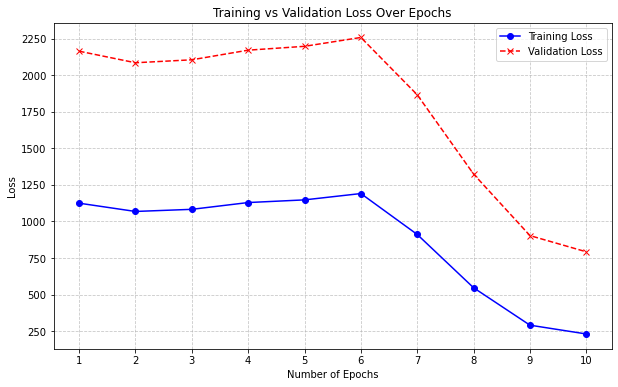



-------------------------------------------------------------------------------
Learning rate:  0.00036500000000000004    Loop:  1
AMD Time interval  15 min Time period:  6 months
Batch size:  16 Number of workers:  0 Epochs:  100
Learning rate scheduler rate:  0.75
Beta1:  0.95 Beta2:  0.999
-------------------------------------------------------------------------------


/home/lb/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/lb/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Training: Epoch 10/100, Loss: 1183.375732
                  Validation: Epoch 10/100, Loss: 2245.659668
Training: Epoch 20/100, Loss: 1050.994873
                  Validation: Epoch 20/100, Loss: 2059.801270
Training: Epoch 30/100, Loss: 1108.455688
                  Validation: Epoch 30/100, Loss: 2141.405029
Training: Epoch 40/100, Loss: 1231.089844
                  Validation: Epoch 40/100, Loss: 2311.804688
Training: Epoch 50/100, Loss: 1176.748413
                  Validation: Epoch 50/100, Loss: 2238.151367
Training: Epoch 60/100, Loss: 1270.823975
                  Validation: Epoch 60/100, Loss: 2366.598633
Training: Epoch 70/100, Loss: 496.972717
                  Validation: Epoch 70/100, Loss: 1245.372314
Training: Epoch 80/100, Loss: 270.885406
                  Validation: Epoch 80/100, Loss: 866.955200
Training: Epoch 90/100, Loss: 164.972473
                  Validation: Epoch 90/100, Loss: 663.879761
Training: Epoch 100/100, Loss: 131.526794
                  Validatio

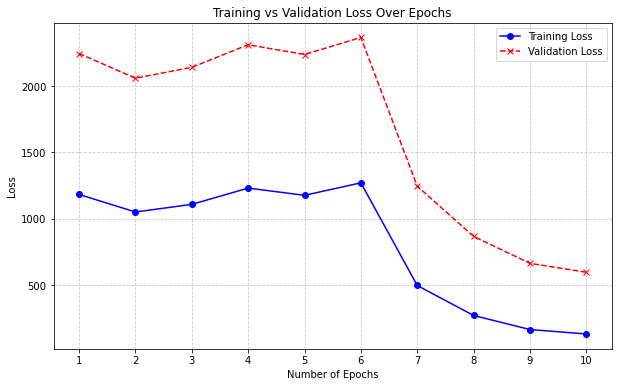



-------------------------------------------------------------------------------
Learning rate:  0.00032    Loop:  1
AMD Time interval  15 min Time period:  6 months
Batch size:  16 Number of workers:  0 Epochs:  100
Learning rate scheduler rate:  0.75
Beta1:  0.95 Beta2:  0.999
-------------------------------------------------------------------------------


/home/lb/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/lb/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Training: Epoch 10/100, Loss: 1296.236572
                  Validation: Epoch 10/100, Loss: 2400.913086
Training: Epoch 20/100, Loss: 1077.307617
                  Validation: Epoch 20/100, Loss: 2097.316650
Training: Epoch 30/100, Loss: 1122.905762
                  Validation: Epoch 30/100, Loss: 2162.086426
Training: Epoch 40/100, Loss: 1160.349854
                  Validation: Epoch 40/100, Loss: 2215.017090
Training: Epoch 50/100, Loss: 1228.952637
                  Validation: Epoch 50/100, Loss: 2310.259766
Training: Epoch 60/100, Loss: 1004.581787
                  Validation: Epoch 60/100, Loss: 1998.981079
Training: Epoch 70/100, Loss: 774.169189
                  Validation: Epoch 70/100, Loss: 1666.981079
Training: Epoch 80/100, Loss: 358.361450
                  Validation: Epoch 80/100, Loss: 1019.594543
Training: Epoch 90/100, Loss: 211.005096
                  Validation: Epoch 90/100, Loss: 757.350586
Training: Epoch 100/100, Loss: 164.392883
                  Validati

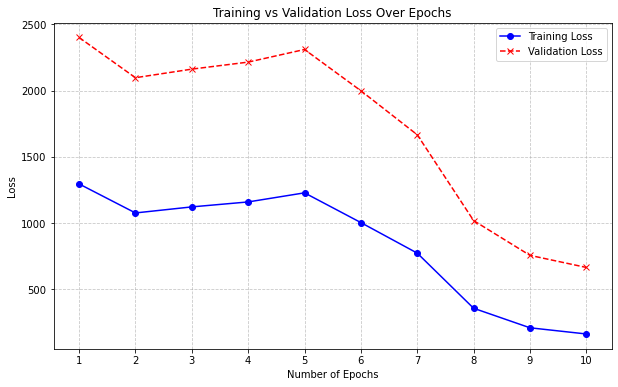



-------------------------------------------------------------------------------
Learning rate:  0.000275    Loop:  1
AMD Time interval  15 min Time period:  6 months
Batch size:  16 Number of workers:  0 Epochs:  100
Learning rate scheduler rate:  0.75
Beta1:  0.95 Beta2:  0.999
-------------------------------------------------------------------------------


/home/lb/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/lb/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Training: Epoch 10/100, Loss: 1528.248779
                  Validation: Epoch 10/100, Loss: 2713.919922
Training: Epoch 20/100, Loss: 1105.793213
                  Validation: Epoch 20/100, Loss: 2137.771973
Training: Epoch 30/100, Loss: 1144.138184
                  Validation: Epoch 30/100, Loss: 2192.111816
Training: Epoch 40/100, Loss: 1094.311157
                  Validation: Epoch 40/100, Loss: 2124.025146
Training: Epoch 50/100, Loss: 1237.853638
                  Validation: Epoch 50/100, Loss: 2322.017822
Training: Epoch 60/100, Loss: 1245.906982
                  Validation: Epoch 60/100, Loss: 2320.313965
Training: Epoch 70/100, Loss: 694.465637
                  Validation: Epoch 70/100, Loss: 1549.352173
Training: Epoch 80/100, Loss: 344.388824
                  Validation: Epoch 80/100, Loss: 995.906250
Training: Epoch 90/100, Loss: 225.177551
                  Validation: Epoch 90/100, Loss: 783.771606
Training: Epoch 100/100, Loss: 210.793427
                  Validatio

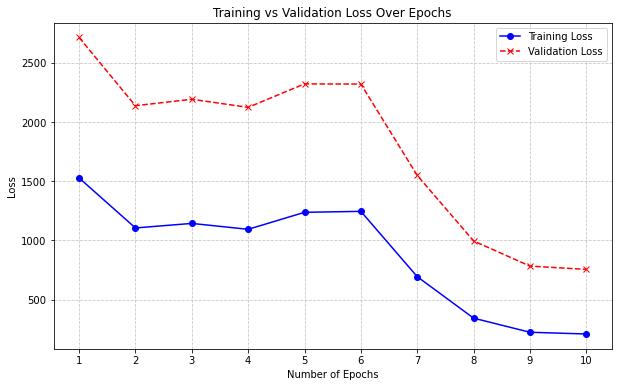



-------------------------------------------------------------------------------
Learning rate:  0.00023000000000000006    Loop:  1
AMD Time interval  15 min Time period:  6 months
Batch size:  16 Number of workers:  0 Epochs:  100
Learning rate scheduler rate:  0.75
Beta1:  0.95 Beta2:  0.999
-------------------------------------------------------------------------------


/home/lb/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/lb/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Training: Epoch 10/100, Loss: 2008.133667
                  Validation: Epoch 10/100, Loss: 3343.194824
Training: Epoch 20/100, Loss: 1135.738281
                  Validation: Epoch 20/100, Loss: 2180.170410
Training: Epoch 30/100, Loss: 1129.572632
                  Validation: Epoch 30/100, Loss: 2171.497803
Training: Epoch 40/100, Loss: 1060.719727
                  Validation: Epoch 40/100, Loss: 2076.433105
Training: Epoch 50/100, Loss: 1335.388672
                  Validation: Epoch 50/100, Loss: 2454.387695
Training: Epoch 60/100, Loss: 1194.932495
                  Validation: Epoch 60/100, Loss: 2249.490723
Training: Epoch 70/100, Loss: 212.914948
                  Validation: Epoch 70/100, Loss: 729.495605
Training: Epoch 80/100, Loss: 167.008698
                  Validation: Epoch 80/100, Loss: 655.844727
Training: Epoch 90/100, Loss: 102.535263
                  Validation: Epoch 90/100, Loss: 515.255005
Training: Epoch 100/100, Loss: 69.638138
                  Validation:

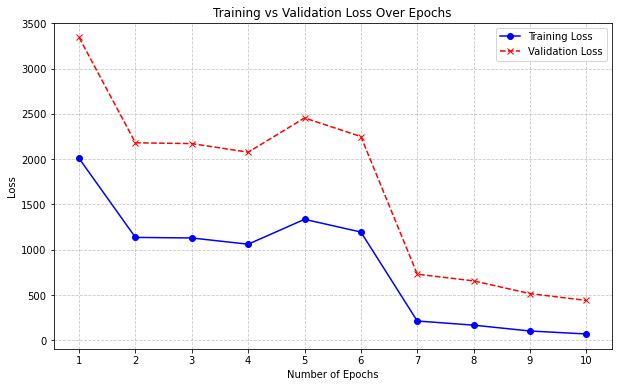



-------------------------------------------------------------------------------
Learning rate:  0.00018500000000000005    Loop:  1
AMD Time interval  15 min Time period:  6 months
Batch size:  16 Number of workers:  0 Epochs:  100
Learning rate scheduler rate:  0.75
Beta1:  0.95 Beta2:  0.999
-------------------------------------------------------------------------------


/home/lb/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/lb/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Training: Epoch 10/100, Loss: 2900.149902
                  Validation: Epoch 10/100, Loss: 4471.125000
Training: Epoch 20/100, Loss: 1174.756348
                  Validation: Epoch 20/100, Loss: 2235.014160
Training: Epoch 30/100, Loss: 1182.635132
                  Validation: Epoch 30/100, Loss: 2246.578613
Training: Epoch 40/100, Loss: 1111.177490
                  Validation: Epoch 40/100, Loss: 2148.447266
Training: Epoch 50/100, Loss: 900.714355
                  Validation: Epoch 50/100, Loss: 1851.028931
Training: Epoch 60/100, Loss: 359.570618
                  Validation: Epoch 60/100, Loss: 1021.649475
Training: Epoch 70/100, Loss: 196.580399
                  Validation: Epoch 70/100, Loss: 728.877075
Training: Epoch 80/100, Loss: 144.438400
                  Validation: Epoch 80/100, Loss: 624.196777
Training: Epoch 90/100, Loss: 106.157349
                  Validation: Epoch 90/100, Loss: 542.041077
Training: Epoch 100/100, Loss: 81.869514
                  Validation: E

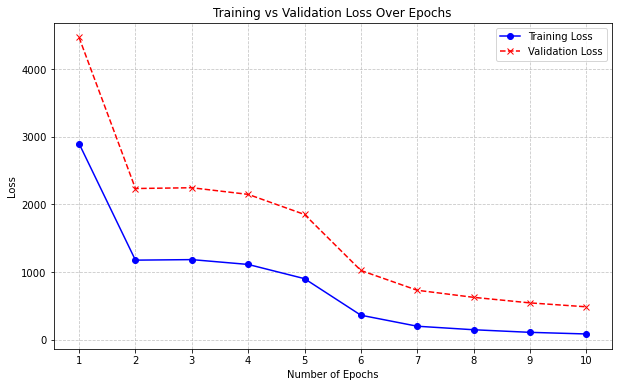



-------------------------------------------------------------------------------
Learning rate:  0.00014000000000000004    Loop:  1
AMD Time interval  15 min Time period:  6 months
Batch size:  16 Number of workers:  0 Epochs:  100
Learning rate scheduler rate:  0.75
Beta1:  0.95 Beta2:  0.999
-------------------------------------------------------------------------------


/home/lb/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/lb/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Training: Epoch 10/100, Loss: 4537.559570
                  Validation: Epoch 10/100, Loss: 6461.020020
Training: Epoch 20/100, Loss: 1318.453369
                  Validation: Epoch 20/100, Loss: 2432.691895
Training: Epoch 30/100, Loss: 1302.242310
                  Validation: Epoch 30/100, Loss: 2410.085205
Training: Epoch 40/100, Loss: 1287.575806
                  Validation: Epoch 40/100, Loss: 2390.655273
Training: Epoch 50/100, Loss: 803.917114
                  Validation: Epoch 50/100, Loss: 1710.661865
Training: Epoch 60/100, Loss: 408.503235
                  Validation: Epoch 60/100, Loss: 1102.819702
Training: Epoch 70/100, Loss: 257.075500
                  Validation: Epoch 70/100, Loss: 842.115051
Training: Epoch 80/100, Loss: 198.436722
                  Validation: Epoch 80/100, Loss: 731.472229
Training: Epoch 90/100, Loss: 147.482452
                  Validation: Epoch 90/100, Loss: 629.385315
Training: Epoch 100/100, Loss: 113.904877
                  Validation: 

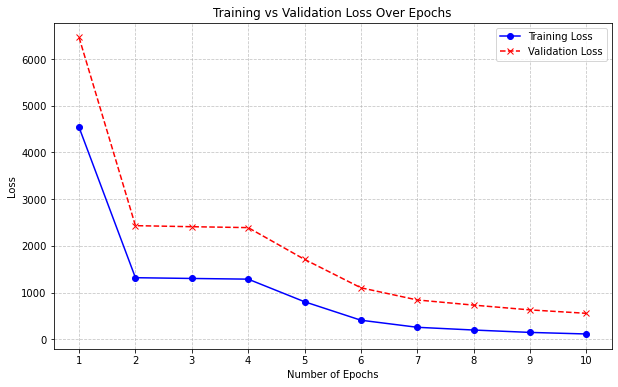



-------------------------------------------------------------------------------
Learning rate:  9.500000000000003e-05    Loop:  1
AMD Time interval  15 min Time period:  6 months
Batch size:  16 Number of workers:  0 Epochs:  100
Learning rate scheduler rate:  0.75
Beta1:  0.95 Beta2:  0.999
-------------------------------------------------------------------------------


/home/lb/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/lb/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Training: Epoch 10/100, Loss: 7211.097656
                  Validation: Epoch 10/100, Loss: 9592.914062
Training: Epoch 20/100, Loss: 2392.298340
                  Validation: Epoch 20/100, Loss: 3835.775146
Training: Epoch 30/100, Loss: 1264.569702
                  Validation: Epoch 30/100, Loss: 2359.897217
Training: Epoch 40/100, Loss: 1203.517944
                  Validation: Epoch 40/100, Loss: 2276.196045
Training: Epoch 50/100, Loss: 893.130493
                  Validation: Epoch 50/100, Loss: 1840.431519
Training: Epoch 60/100, Loss: 466.407867
                  Validation: Epoch 60/100, Loss: 1197.673218
Training: Epoch 70/100, Loss: 282.016083
                  Validation: Epoch 70/100, Loss: 887.999084
Training: Epoch 80/100, Loss: 186.327576
                  Validation: Epoch 80/100, Loss: 709.964478
Training: Epoch 90/100, Loss: 150.025299
                  Validation: Epoch 90/100, Loss: 637.177246
Training: Epoch 100/100, Loss: 124.148949
                  Validation: 

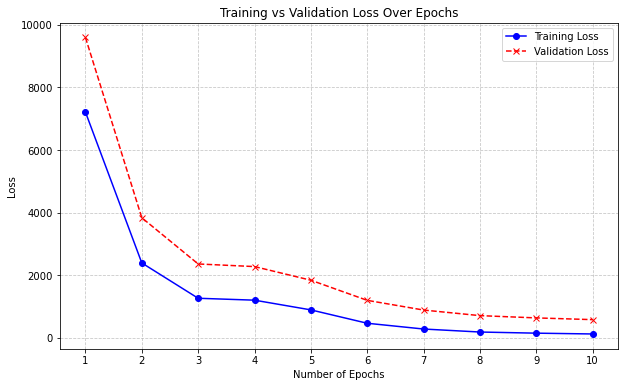



Best learning rate:  0.0005    Loss:  tensor(0.0014, device='cuda:0', grad_fn=<MseLossBackward0>)
Second best learning rate:  0.00041    Loss:  tensor(0.0015, device='cuda:0', grad_fn=<MseLossBackward0>)


In [69]:
learning_rate_list = []
difference_of_lr = best_lr[0][1] - best_lr[1][1]
number_of_increments = 10
increment = difference_of_lr / number_of_increments

for i in range(number_of_increments):
    learning_rate_list.append(best_lr[0][1] - increment * i)

for lr in learning_rate_list:
    print("\n\n-------------------------------------------------------------------------------")
    print("Learning rate: ", lr, "   Loop: ", repeated_loops_per_lr)
    print(stock_name, "Time interval ", stock_interval, "min", "Time period: ", stock_period, 'months')
    print("Batch size: ", batch_size, "Number of workers: ", num_workers, "Epochs: ", epochs)
    print("Learning rate scheduler rate: ", lr_scheduler_rate)
    print("Beta1: ", beta1, "Beta2: ", beta2)
    print("-------------------------------------------------------------------------------")

    
    
    for i in range(repeated_loops_per_lr):
        training_loss_array = []
        validation_loss_array = []
        rnn1 = RNN_initializer(retrieve=True, name=stock_name, recomp=True, nval=1, ival=[5, "m"], pval=[7,"d"], batch_size=batch_size, num_workers=num_workers, epochs=epochs, learning_rate=lr, lr_scheduler_rate=lr_scheduler_rate, beta1=beta1, beta2=beta2)
        loss = rnn1.trainAndTest()
        if best_lr_in_loop > loss:
            best_lr_in_loop = loss

    if best_lr_in_loop < best_lr[0][0]:
        best_lr[1] = best_lr[0]
        best_lr[0] = [best_lr_in_loop, lr]
    elif best_lr_in_loop < best_lr[1][0]:
        best_lr[1] = [best_lr_in_loop, lr]

    best_lr_in_loop = np.inf


    plot_loss(training_loss_array, validation_loss_array, epochs)


print("\n\nBest learning rate: ", best_lr[0][1], "   Loss: ", best_lr[0][0])
print("Second best learning rate: ", best_lr[1][1], "   Loss: ", best_lr[1][0])

In [19]:
if stock_data_source == "yahoo":
    #Stock variables when using yahoo finance api
    stock_name = "AMD"
    stock_interval="5m"
    stock_period="7d"
    epochs = 100
    lr_scheduler_rate = 0.8
    beta1 = 0.9
    beta2 = 0.999

#Stock variables when using alpaca api
if stock_data_source == "alpaca":
    stock_name = "AMD"
    stock_interval="15"
    stock_period="24" #months
    epochs = 200
    lr_scheduler_rate = 0.1
    beta1 = 0.95
    beta2 = 0.999

batch_size = 16
num_workers = 0

In [ ]:

#test previous god perfoming rates learning rates
learning_rate_list = [0.00018, 0.00016, 0.00014, 0.00012]
best_lr = [[np.inf, np.inf] , [np.inf, np.inf]] #record two pairs of [loss, learning rate] to tune learning rate later
best_lr_in_loop = np.inf
repeated_loops_per_lr = 3

for lr in learning_rate_list:
    print("\n\n-------------------------------------------------------------------------------")
    print("Learning rate: ", lr, "   Loop: ", repeated_loops_per_lr)
    print(stock_name, "Time interval ", stock_interval, "min", "Time period: ", stock_period, 'months')
    print("Batch size: ", batch_size, "Number of workers: ", num_workers, "Epochs: ", epochs)
    print("Learning rate scheduler rate: ", lr_scheduler_rate)
    print("Beta1: ", beta1, "Beta2: ", beta2)
    print("-------------------------------------------------------------------------------")
    
    for i in range(repeated_loops_per_lr):
        training_loss_array = []
        validation_loss_array = []
        rnn1 = RNN_initializer(retrieve=True, name=stock_name, recomp=True, nval=1, ival=[5, "m"], pval=[7,"d"], batch_size=batch_size, num_workers=num_workers, epochs=epochs, learning_rate=lr, lr_scheduler_rate=lr_scheduler_rate, beta1=beta1, beta2=beta2)
        loss = rnn1.trainAndTest()
        if best_lr_in_loop > loss:
            best_lr_in_loop = loss

    if best_lr_in_loop < best_lr[0][0]:
        best_lr[1] = best_lr[0]
        best_lr[0] = [best_lr_in_loop, lr]
    elif best_lr_in_loop < best_lr[1][0]:
        best_lr[1] = [best_lr_in_loop, lr]

    #plot_loss(training_loss_array, validation_loss_array, epochs)



-------------------------------------------------------------------------------
Learning rate:  0.00018    Loop:  3
AMD Time interval  15 min Time period:  24 months
Batch size:  16 Number of workers:  0 Epochs:  200
Learning rate scheduler rate:  0.1
Beta1:  0.95 Beta2:  0.999
-------------------------------------------------------------------------------


KeyboardInterrupt: 

In [ ]:
#output,hidden = rnn1(price_tensor)
#print(output.shape)  # (1, 1, 128)
#print(hidden.shape)  # (2, 1, 128)
  # Predict 1 value from hidden_size=128

#prediction = fc(output[:, -1, :])  # Take output at last time step
#print(prediction)

## Test the Trained Network
---
Test your trained model on previously unseen data! Remember we have downloaded `train_data` and `test_data`. We will use `test_data` through `test_loader`.

A "good" result will be a CNN that gets around 70% (or more, try your best!) accuracy on these test images.

The following is working code, but you are encouraged to make your own adjustments and enhance the implementation.

### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)
---
Decide on a loss and optimization function that is best suited for this classification task. The linked code examples from above, may be a good starting point; [this PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py) Pay close attention to the value for **learning rate** as this value determines how your model converges to a small error.

The following is working code, but you can make your own adjustments.

**TODO**: try to compare with ADAM optimizer

In [ ]:
#error = nn.MSELoss()
#optimizer = torch.optim.Adam(prediction.parameters(), lr=0.001)

#epochs = 50
#for epoch in range(epochs):
#    rnn1.train()
#    fc.train()
    
#      output,hidden = rnn1(price_tensor)
#    prediction = fc(output[:, -1, :])
#    loss = error(prediction, y_tensor)
    
#    optimizer.zero_grad()
#    loss.backward()
#    optimizer.step()

#    if (epoch+1) % 10 == 0:
#        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

In [ ]:
# Define your models first
#rnn1 = ...  # Your RNN model definition
#fc = ...    # Your fully connected layer definition

# Define loss and optimizer
error = nn.MSELoss()
optimizer = torch.optim.Adam(list(rnn1.parameters()) + list(fc.parameters()), 
                            lr=0.001, weight_decay=0.001)  # L2 regularization
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

# Add gradient clipping value
clip_value = 1.0

# Add validation set monitoring
best_val_loss = float('inf')
patience = 5
no_improvement = 0

epochs = 50
for epoch in range(epochs):
    rnn1.train()
    fc.train()
    
    # Forward pass
    output, hidden = rnn1(price_tensor)
    prediction = fc(output[:, -1, :])
    loss = error(prediction, y_tensor)
    
    # Backward pass with gradient clipping
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(list(rnn1.parameters()) + list(fc.parameters()), clip_value)
    optimizer.step()
    
    # Update learning rate
    scheduler.step(loss)
    
    # Early stopping check
    if loss.item() < best_val_loss:
        best_val_loss = loss.item()
        no_improvement = 0
    else:
        no_improvement += 1
        if no_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

AttributeError: 'RNN_initializer' object has no attribute 'parameters'